In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV,Lasso, LassoLarsCV, LinearRegression,RANSACRegressor
from sklearn.model_selection import cross_val_score,KFold,train_test_split,cross_val_predict, StratifiedKFold
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import *
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from pandas.tools.plotting import scatter_matrix
import statsmodels.formula.api as sm
from scipy.stats import norm
import datetime 
import scipy
from  datetime  import datetime as dt 
from scipy import stats
import operator
from sklearn import cross_validation, grid_search, linear_model, metrics

from sklearn.feature_selection import VarianceThreshold
import re
# import warnings 
# warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [31]:
min(data.meas_date)

datetime.date(16, 5, 28)

In [36]:
1.*166/9198

0.018047401609045444

In [37]:
len(data.meas_date.unique())

112

In [2]:
data = pd.read_csv('dataset1707.csv', sep=';') #
# data = data.loc[data.IS_FIRST==0]
agg686 = pd.read_csv('./doone/fin686.csv', sep=';') #
agg685 = pd.read_csv('./doone/fin685.csv', sep=';') 
agg641 = pd.read_csv('./doone/fin641.csv', sep=';') #
agg560 = pd.read_csv('./doone/fin560.csv', sep=';') #

agg68 = pd.concat([agg686, agg685], ignore_index=1)

data = data.loc[(data['TMP_STP_ALL_AVG']>360)&(data['TMP_STP_ALL_AVG']<700)&(data.TEMP_START_PHASE1!=0)&((data.ADAPTATION_KEY==190409109015)|(data.ADAPTATION_KEY==190309109015))]

data.drop(['TMP_STRT_HED_AVG_M','TMP_STRT_TAIL_AVG_M', 'PROFILE_SDV', u'PROFILE_MIN', u'PROFILE_AVG', u'PROFILE_MAX'], axis=1, inplace=True)
data = data.dropna()

In [4]:
data.loc[(data.BATCH_POSITION==1)&(data.IS_FIRST==1)].NOT_IN_40_0C.sum()

8L

In [ ]:
10 + 8

In [23]:
data.groupby('meas_date')['NOT_IN_40_0C'].count().min()

3

In [24]:
1.5/82.9

0.0180940892641737

In [9]:
len(data.loc[(data.NOT_IN_25_0C==1)&(data.NOT_IN_40_0C==0)])

166

In [29]:
data['Vol'] = data['PLT_TCK']*data['PLT_WID']*data['PLT_LEN']*1e-09
data['MEAS_TIME'] = data['MEAS_TIME'].apply(lambda x: dt.strptime(x, "%d.%m.%Y %H:%M:%S"))
data['PREV_MEAS_TIME'] = data['PREV_MEAS_TIME'].apply(lambda x: dt.strptime(x, "%d.%m.%Y %H:%M:%S"))

data['ts_diff'] = (data['TS'] - data['TMP_STP_ALL_AVG']).shift().fillna((data['TS'] - data['TMP_STP_ALL_AVG']).median())  

data['hour'] = 0
data['hour'] = data['MEAS_TIME'].apply(lambda x: x.hour)
data['month']=0
data['month'] = data['MEAS_TIME'].apply(lambda x: x.month)

data['fail'] = 0
data.ix[data.NOT_IN_25_0C==1, 'fail'] = 1
data['meas_date'] =  data['MEAS_TIME'].apply(lambda x: x.date())
data['prev_meas_date'] = data['PREV_MEAS_TIME'].apply(lambda x: x.date())

gg_time = pd.merge(data[[ 'meas_date', 'MEAS_TIME']], data[[ 'meas_date', 'MEAS_TIME','fail']], on='meas_date', how='left')
gg_time['idt'] = 0
gg_time['idt'] = gg_time.MEAS_TIME_x.apply(lambda x: str(x))

# gg_fail =  gg_time.loc[(gg_time.MEAS_TIME_x>gg_time.MEAS_TIME_y)&(gg_time.fail==1)].groupby('idt')['MEAS_TIME_y'].max().reset_index()
# gg_fail.columns = ['MEAS_TIME', 'MEAS_LAST_FAIL']
# gg_fail['MEAS_TIME'] = gg_fail['MEAS_TIME'].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S"))
# data = pd.merge(data, gg_fail, on='MEAS_TIME', how='left')
# data['mins_since_fail'] = (data.MEAS_TIME - data.MEAS_LAST_FAIL).apply(lambda x: x.total_seconds()/60)
# data['mins_since_fail'].fillna(data.mins_since_fail.mean(), inplace=True)


data['diff_mins'] = data['MEAS_TIME'] - data['PREV_MEAS_TIME']
data['diff_mins'] = data['diff_mins'].apply(lambda x: round(x.total_seconds()/60,2))
data['weekday'] = data['MEAS_TIME'].apply(lambda x: x.weekday())
# data['first_cool'] = (data['MEAS_TIME'].apply(lambda x: x.date()) - data['PREV_MEAS_TIME'].apply(lambda x: x.date())).apply(lambda x: x.days)
# data.ix[data.first_cool>0, 'first_cool'] = 1

data['prev_fail'] = data['fail'].shift().fillna(0) 
data['CR_PREV'] = (data['CR_ACT'] - data['CR']).shift().fillna((data['CR_ACT'] - data['CR']).median())  
data['ADAPT_TS_MEAN_PREV'] = data['ADAPT_TS_MEAN'].shift().fillna(data['ADAPT_TS_MEAN'].median())  

data['TMP_STP_ALL_PREV'] = data['TMP_STP_ALL_AVG'].shift().fillna(data.TMP_STP_ALL_AVG.median())  
# data['tail_head_diff'] = data['TMP_STRT_HEAD_AVG']- data['TMP_STRT_TAIL_AVG']

data['daypart'] = 0
data.ix[(data.hour>8)&(data.hour<=12), 'daypart'] = 1
data.ix[(data.hour>12)&(data.hour<=16), 'daypart'] = 2
data.ix[(data.hour>16)&(data.hour<=20), 'daypart'] = 3
data.ix[(data.hour>20)&(data.hour<=23), 'daypart'] = 4



not25day = data.groupby('meas_date')['NOT_IN_25_0C'].sum().reset_index()
not40day = data.groupby('meas_date')['NOT_IN_40_0C'].sum().reset_index()

not25day.columns = ['meas_date', 'not25day']

not40day.columns = ['meas_date', 'not40day']

data = pd.merge(pd.merge(data,not25day , on='meas_date'), not40day, on='meas_date')


for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>4, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
for col in [ u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>36, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
for col in [ 'EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>9, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
    
for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
    data[col] = data[col].apply(lambda x: [float(i) for i in x])
    

# for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
#        u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
#     data[col+'_sum'] = data[col].apply(lambda x: sum(x))
    
for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
    data[col] = data[col].apply(lambda x: np.mean(x))
    
    
    
for col in ['SIDE_SPRAY', 'AIR_BLOWER'] :
    data[col] = data[col].apply(lambda x: str(x.count('0')))
    


agg68.rename(columns={'pltid':'PIECE_ID'}, inplace=1)

df = pd.merge(agg68, data, on='PIECE_ID')    


df.ix[df.month==1,'month']=13
df.ix[df.month==2,'month']=14

# df['40up'] = 0
# df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG>480), '40up']=1
# df['40down'] = 0
# df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG<480), '40down']=1
# df['25up'] = 0
# df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG>480), '25up']=1
# df['25down'] = 0
# df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG<480), '25down']=1

df['outcome'] = 0
df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG>510), 'outcome']=1

df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG<450), 'outcome']=2

df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG>480), 'outcome']=3

df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG<480),'outcome']=4

todrop = ['GFC.GlobVar.GfcLocRtData.GfcSccWatPrsScc_median', 'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioManRef_ActV_mean',
          'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioManRef_ActV_median', 'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioManRef_ActV_std',
          'GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskLenBot_SetV_std', 'GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskLenTop_SetV_std', 
          'GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwBot_SetV_std', 'GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwTop_SetV_std','dist_from plt_mean_std',
          'dist_from plt_sum_std', 'L_ACC','CR','WBF_NO','PODKAT','PODKAT2','PLT_TCK','PLT_WID','PLT_LEN',
          'NOT_ANALYSIS', 'fail']
    
df.drop(todrop, axis=1, inplace=1)
df.fillna(0, axis=1, inplace=1)

df['BHC_out_flow_sum_diff']=df[ 'BHC_out_act_sum_mean']-df['BHC_flow__out_sum_task_mean']
df['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff'] =  df['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_mean']-df['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_task_mean']
df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_diff'] =df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_mean'] - df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_task_mean']
df['THC_cen_flow_sum_diff'] = df['THC_cen_flow_sum_act_mean'] - df[ 'THC_flow_cen_sum_task_mean']
df['THC_out_degree_sum_diff'] = df['THC_out_degree_sum_act_mean'] - df['THC_out_degree_sum_task_mean']
df['THC_out_flow_sum_diff'] = df['THC_out_flow_sum_act_mean'] - df[ 'THC_out_flow_sum_task_mean']
    
fail40up = df.loc[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG>500)]
fail40down = df.loc[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG<500)]
fail25up = df.loc[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG>480)&(df.NOT_IN_40_0C==0)]
fail25down = df.loc[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG<460)&(df.NOT_IN_40_0C==0)]

good = df.loc[(df.TMP_STP_ALL_AVG<482.5)&(df.TMP_STP_ALL_AVG>477.5)]


ad3 = df.loc[df.ADAPTATION_KEY==190309109015]
ad4 = df.loc[df.ADAPTATION_KEY==190409109015]

suspup = df.loc[(df.TMP_STP_ALL_AVG>500)&(df.NOT_IN_40_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
suspdown = df.loc[(df.TMP_STP_ALL_AVG<480)&(df.NOT_IN_40_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
    
susp25up = df.loc[(df.TMP_STP_ALL_AVG>500)&(df.NOT_IN_25_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
susp25down = df.loc[(df.TMP_STP_ALL_AVG<480)&(df.NOT_IN_25_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
  
susp25up2 = df.loc[(df.NOT_IN_40_0C==0)&(df.TMP_STP_ALL_AVG>500)&(df.NOT_IN_25_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
susp25down2 = df.loc[(df.NOT_IN_40_0C==0)&(df.TMP_STP_ALL_AVG<480)&(df.NOT_IN_25_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]

numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object' and c!='ADAPTATION_KEY' and c not in ['PPS_PIECE_ID', 'PIECE_ID', 'PIECE_ID_1', 'PIECE_ID_2']]

# df['outcome'] = 0
# df.ix[df.PIECE_ID.isin(fail40up.PIECE_ID), 'outcome'] = 1
# df.ix[df.PIECE_ID.isin(fail25up.PIECE_ID), 'outcome'] = 2
# df.ix[df.PIECE_ID.isin(fail40down.PIECE_ID), 'outcome'] = 3
# df.ix[df.PIECE_ID.isin(fail25down.PIECE_ID), 'outcome'] = 4
# df.ix[df.PIECE_ID.isin(good.PIECE_ID), 'outcome'] = 5

cols = df.columns.difference(['PPS_PIECE_ID','PIECE_ID','PREV_PIECE_ID ','PIECE_ID_2','PIECE_ID_1', 'MEAS_TIME', 'PREV_MEAS_TIME', 'PREV_PIECE_ID', 'NOT_IN_25_0C','NOT_IN_40_0C','IS_FIRST','outcome'])


In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',264)

h = pd.concat([fail40up[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
h.columns = ['index', 'fail40up_mean','good_mean']

h['diff']=0
h['diff'] = abs((h.fail40up_mean - h.good_mean)/(h['good_mean']))
h.sort_values(by='diff', ascending=0,inplace=1)
h.to_csv('./t/fail40up.csv',index=0, sep=';' )
h

IOError: [Errno 2] No such file or directory: './t/fail40up.csv'

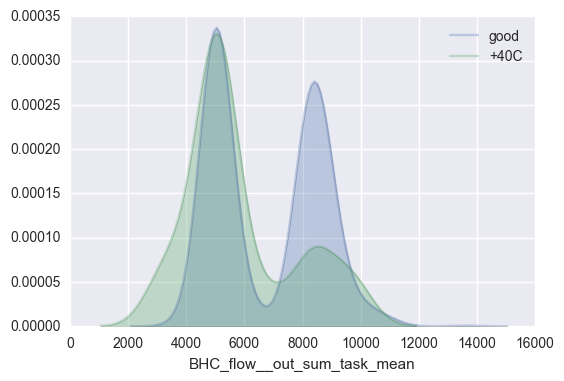

In [161]:
fig, ax = plt.subplots()
sns.distplot(good['BHC_flow__out_sum_task_mean'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(fail40up['BHC_flow__out_sum_task_mean'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+40C')

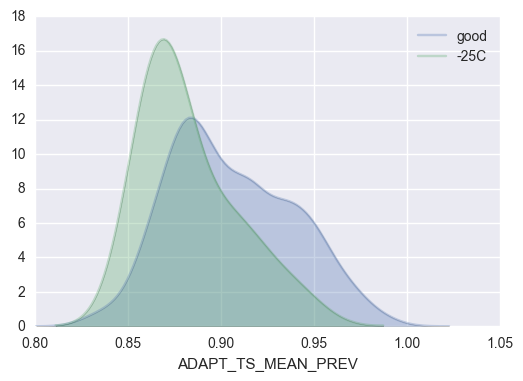

In [14]:
fig, ax = plt.subplots()
sns.distplot(good['ADAPT_TS_MEAN_PREV'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down2['ADAPT_TS_MEAN_PREV'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

In [16]:
data[['ADAPT_TS_MEAN_PREV','TMP_STP_ALL_AVG']].corr()

,ADAPT_TS_MEAN_PREV,TMP_STP_ALL_AVG
ADAPT_TS_MEAN_PREV,1.000,0.065
TMP_STP_ALL_AVG,0.065,1.000


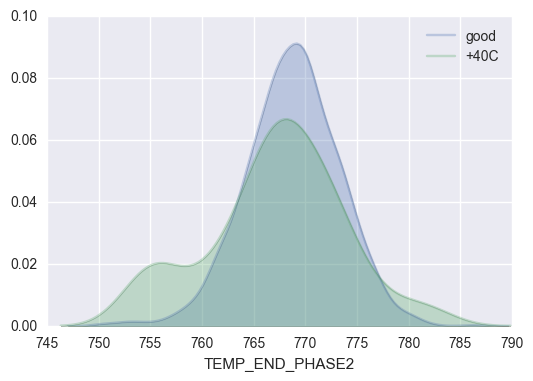

In [5]:
fig, ax = plt.subplots()
sns.distplot(good['TEMP_END_PHASE2'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(fail40up['TEMP_END_PHASE2'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+40C')

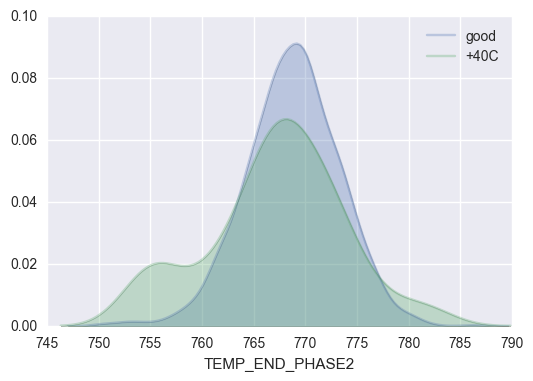

In [6]:
fig, ax = plt.subplots()
sns.distplot(good['TEMP_END_PHASE2'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(fail40up['TEMP_END_PHASE2'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+40C')

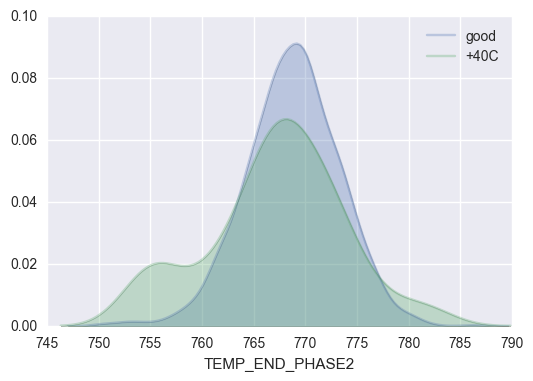

In [7]:
fig, ax = plt.subplots()
sns.distplot(good['TEMP_END_PHASE2'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(fail40up['TEMP_END_PHASE2'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+40C')

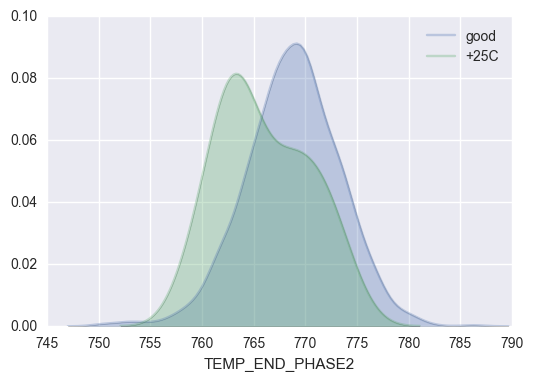

In [8]:
fig, ax = plt.subplots()
sns.distplot(good['TEMP_END_PHASE2'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25up2['TEMP_END_PHASE2'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+25C')

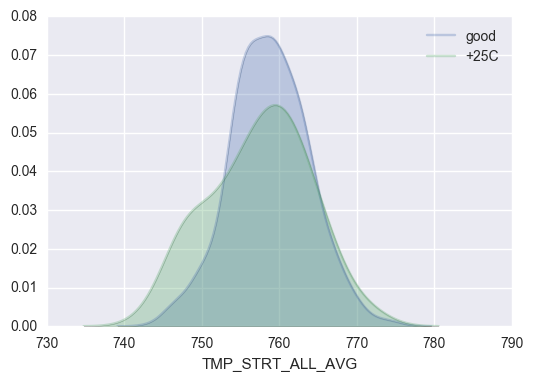

In [156]:
fig, ax = plt.subplots()
sns.distplot(good['TMP_STRT_ALL_AVG'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25up['TMP_STRT_ALL_AVG'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+25C')

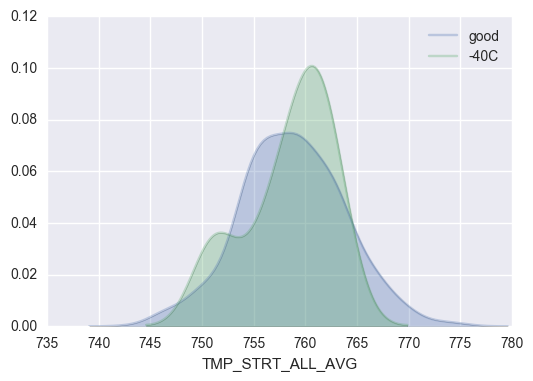

In [153]:
fig, ax = plt.subplots()
sns.distplot(good['TMP_STRT_ALL_AVG'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(fail40down['TMP_STRT_ALL_AVG'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-40C')

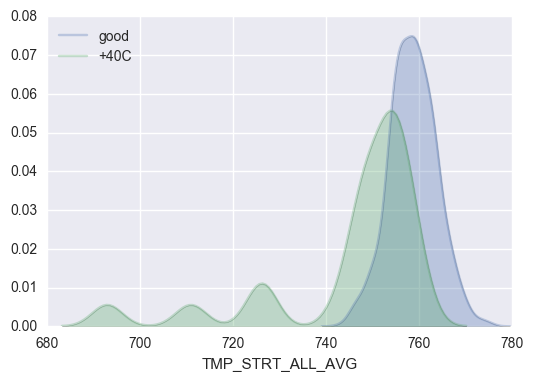

In [151]:
fig, ax = plt.subplots()
sns.distplot(good['TMP_STRT_ALL_AVG'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(fail40up['TMP_STRT_ALL_AVG'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+40C')

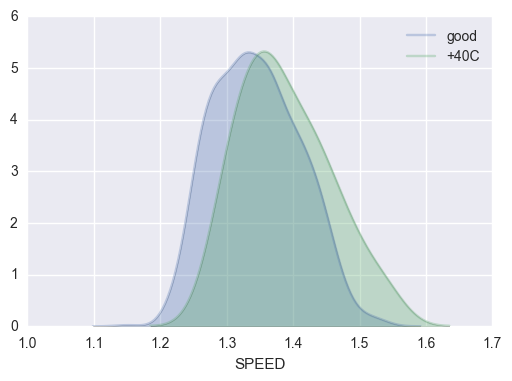

In [177]:
fig, ax = plt.subplots()
sns.distplot(good['SPEED'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25up2['SPEED'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+25C')

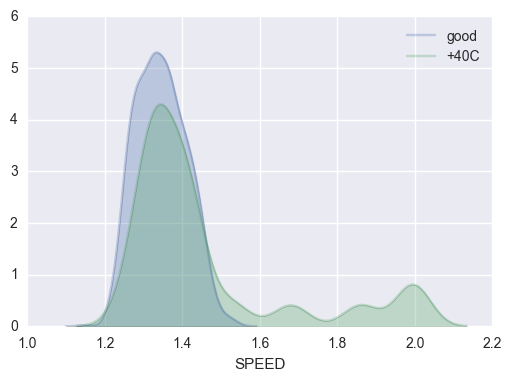

In [149]:
fig, ax = plt.subplots()
sns.distplot(good['SPEED'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(fail40up['SPEED'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+40C')

In [5]:
todrop2 = [ 'L_ACC','CR','WBF_NO','PODKAT','PODKAT2','PLT_TCK','PLT_WID','PLT_LEN','prev_meas_date',
          'NOT_ANALYSIS', 'fail','PPS_PIECE_ID','PIECE_ID','PIECE_ID_2','PIECE_ID_1','PREV_PIECE_ID', 'meas_date', 'MEAS_TIME', 'PREV_MEAS_TIME']
    
data.drop(todrop2, axis=1, inplace=1)

In [6]:
c = ['TMP_STRT_TOT_AVG_M',
 'TMP_STRT_BDY_AVG_M',
 'TMP_STRT_TOT_MAX_M',
 'TMP_STA_TOT_MIN_M',

 'TMP_STRT_HEAD_AVG',
 'TMP_STRT_HEAD_MIN',
 'TMP_STRT_HEAD_MAX',
 'TMP_STRT_HEAD_DEV',
 'TMP_STRT_BDY_AVG',
 'TMP_STRT_BDY_MIN',
 'TMP_STRT_BDY_MAX',
 'TMP_STRT_BDY_DEV',
 'TMP_STRT_TAIL_AVG',
 'TMP_STRT_TAIL_MIN',
 'TMP_STRT_TAIL_MAX',
 'TMP_STRT_TAIL_DEV',
 'TMP_STRT_ALL_AVG',
 'TMP_STRT_ALL_MIN',
 'TMP_STRT_ALL_MAX',
 'TMP_STRT_ALL_DEV',


 'FURT10',
 'FURT40',


 'UNIFORMITY',

 'TEMP_OVERHEATING',
 'TEMP_START_PHASE1',
 'TEMP_START_PHASE2',
 'TEMP_END_PHASE2',
 'DIF_TEMP_START',
 'DIF_TFM',
 'DIF_STRT_TOT_AVG',
 'DIF_STRT_HED_AVG',
 'DIF_STRT_TAIL_AVG',
 'DIF_STRT_TOT',
 'DIF_BDY_HEAD',
 'DIF_BDY_TAIL',

 'Vol']

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

a = pd.concat([suspup[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
a.columns = ['index', 'susp40up_mean','good_mean']

a['diff']=0
a['diff'] = abs((a.susp40up_mean - a.good_mean)/(a['good_mean']))
a.sort_values(by='diff', ascending=0,inplace=1)
a.to_csv('./t/suspup.csv',index=0, sep=';' )
a

,index,susp40up_mean,good_mean,diff
65,DIF_TMP_ALL,49.131,0.080,616.950
50,DEF_CR,-2.885,-0.064,44.383
116,SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff,-400.606,20.341,20.695
56,DIF_LAM_BDY_TAIL,0.083,-0.008,11.278
53,DIF_BDY_TAIL,0.112,-0.011,11.267
58,DIF_SPRAY_BDY_TAIL,0.029,-0.003,11.235
123,SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_diff,-159.325,16.072,10.913
81,GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMo...,0.000,0.000,9.501
241,not40day,3.154,0.474,5.654
240,not25day,6.231,1.769,2.522


In [183]:
df.shape

(5427, 261)

In [169]:
good.shape

(1017, 261)

In [171]:
suspup.shape

(13, 261)

In [170]:
suspdown.shape

(8, 261)

In [167]:
susp25up.shape

(71, 261)

In [168]:
susp25down.shape

(27, 261)

In [190]:
df.NOT_IN_25_0C.sum()

119L

In [193]:
suspdown.shape[0] +suspup.shape[0]

21

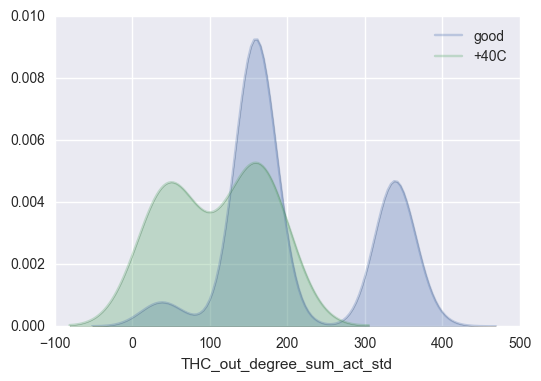

In [129]:
fig, ax = plt.subplots()
sns.distplot(good['THC_out_degree_sum_act_std'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(suspup['THC_out_degree_sum_act_std'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+40C')

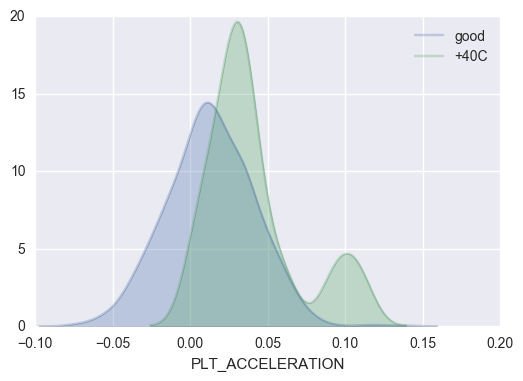

In [123]:
fig, ax = plt.subplots()
sns.distplot(good['PLT_ACCELERATION'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(suspup['PLT_ACCELERATION'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+40C')

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

b= pd.concat([suspdown[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

b.columns = ['index', 'susp40down_mean','good_mean']

b['diff']=0
b['diff'] = abs((b.susp40down_mean - b.good_mean)/(b['good_mean']))
b.sort_values(by='diff', ascending=0,inplace=1)

b.to_csv('./t/suspdown.csv',index=0, sep=';' )
b


,index,susp40down_mean,good_mean,diff
65,DIF_TMP_ALL,-54.165,0.080,682.261
81,GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMo...,0.001,0.000,40.473
50,DEF_CR,1.422,-0.064,23.374
56,DIF_LAM_BDY_TAIL,0.083,-0.008,11.347
53,DIF_BDY_TAIL,0.113,-0.011,11.335
58,DIF_SPRAY_BDY_TAIL,0.030,-0.003,11.303
244,ts_diff,5.369,-0.739,8.264
45,CR_PREV,0.386,-0.069,6.616
241,not40day,3.375,0.474,6.121
240,not25day,6.375,1.769,2.604


In [17]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

j= pd.concat([susp25up[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

j.columns = ['index', 'susp25up_mean','good_mean']
j['diff']=0
j['diff'] = abs((j.susp25up_mean - j.good_mean)/(j['good_mean']))
j.sort_values(by='diff', ascending=0,inplace=1)

# j.to_csv('./t/susp25up.csv',index=0, sep=';' )
j


,index,susp25up_mean,good_mean,diff
66,DIF_TMP_ALL,32.542,0.080,408.298
51,DEF_CR,-1.628,-0.064,24.604
97,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.016,0.002,6.307
117,SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff,-48.240,20.341,3.372
57,DIF_LAM_BDY_TAIL,0.019,-0.008,3.349
54,DIF_BDY_TAIL,0.026,-0.011,3.346
59,DIF_SPRAY_BDY_TAIL,0.007,-0.003,3.339
112,PLT_ACCELERATION,0.041,0.013,2.133
242,not40day,1.423,0.474,2.001
245,ts_diff,-2.051,-0.739,1.775


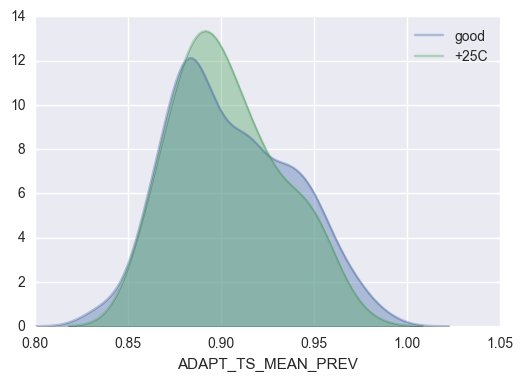

In [19]:
fig, ax = plt.subplots()
sns.distplot(good['ADAPT_TS_MEAN_PREV'], hist=False,kde_kws={"shade": True, 'alpha':0.4}, ax=ax, label='good')
sns.distplot(susp25up2['ADAPT_TS_MEAN_PREV'], hist=False,  kde_kws={"shade": True, 'alpha':0.4},ax=ax, label='+25C')



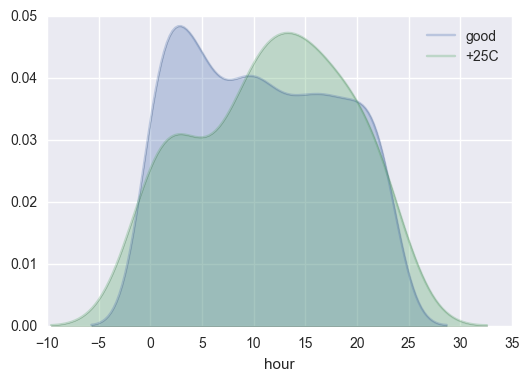

In [110]:
fig, ax = plt.subplots()
sns.distplot(good['hour'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25up['hour'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+25C')

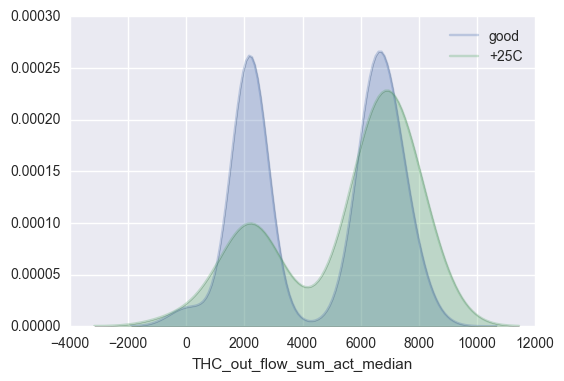

In [80]:
fig, ax = plt.subplots()
sns.distplot(good['THC_out_flow_sum_act_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, label='good', ax=ax)
sns.distplot(susp25up['THC_out_flow_sum_act_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+25C')

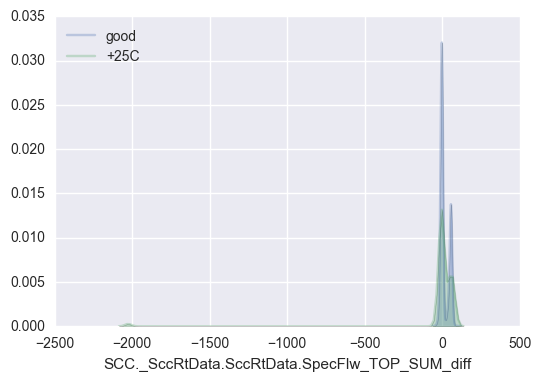

In [81]:
fig, ax = plt.subplots()
sns.distplot(good['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_diff'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25up['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_diff'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+25C')

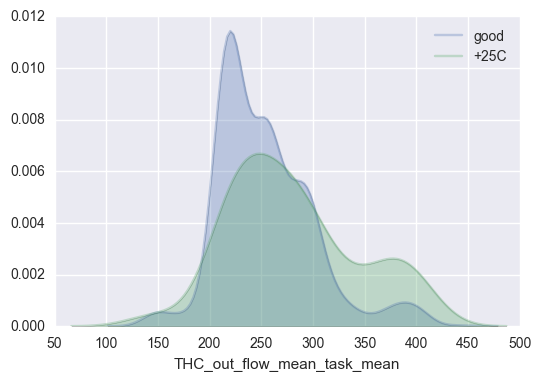

In [82]:
fig, ax = plt.subplots()
sns.distplot(good['THC_out_flow_mean_task_mean'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25up['THC_out_flow_mean_task_mean'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+25C')

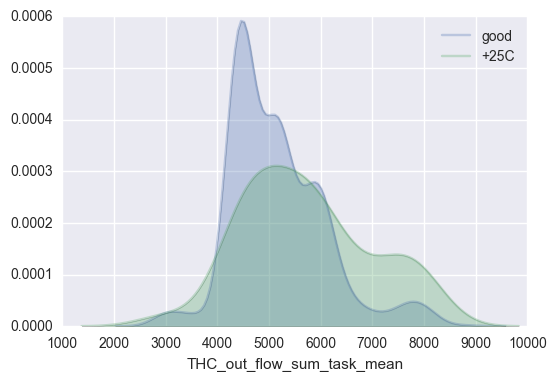

In [83]:
fig, ax = plt.subplots()
sns.distplot(good['THC_out_flow_sum_task_mean'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25up['THC_out_flow_sum_task_mean'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+25C')

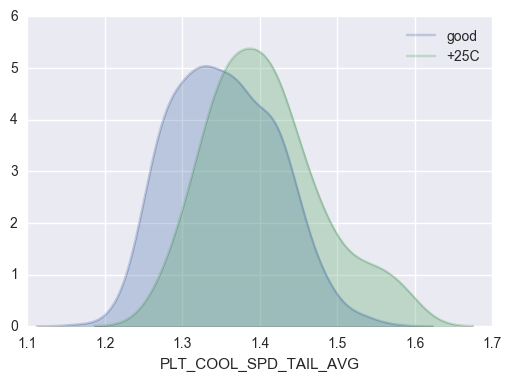

In [106]:
fig, ax = plt.subplots()
sns.distplot(good['PLT_COOL_SPD_TAIL_AVG'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25up['PLT_COOL_SPD_TAIL_AVG'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='+25C')

In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

g= pd.concat([susp25down[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

g.columns = ['index', 'susp25down_mean','good_mean']
g['diff']=0
g['diff'] = abs((g.susp25down_mean - g.good_mean)/(g['good_mean']))
g.sort_values(by='diff', ascending=0,inplace=1)
g.to_csv('./t/susp25down.csv',index=0, sep=';' )
g


,index,susp25down_mean,good_mean,diff
65,DIF_TMP_ALL,-37.151,0.080,468.272
56,DIF_LAM_BDY_TAIL,0.129,-0.008,16.984
53,DIF_BDY_TAIL,0.175,-0.011,16.966
58,DIF_SPRAY_BDY_TAIL,0.046,-0.003,16.916
50,DEF_CR,0.986,-0.064,16.501
81,GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMo...,0.000,0.000,11.655
241,not40day,1.815,0.474,2.829
45,CR_PREV,-0.246,-0.069,2.570
240,not25day,4.704,1.769,1.659
64,DIF_TFM,0.959,-2.214,1.433


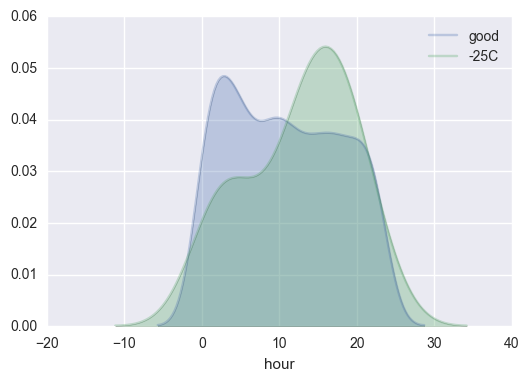

In [108]:
fig, ax = plt.subplots()
sns.distplot(good['hour'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['hour'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

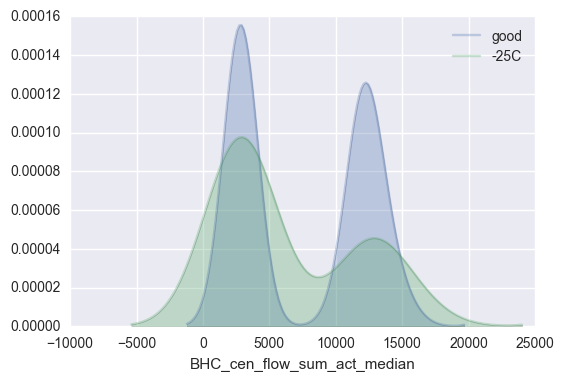

In [98]:
fig, ax = plt.subplots()
sns.distplot(good['BHC_cen_flow_sum_act_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['BHC_cen_flow_sum_act_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

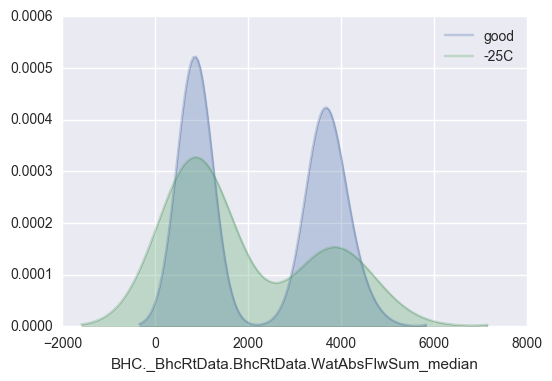

In [97]:
fig, ax = plt.subplots()
sns.distplot(good['BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

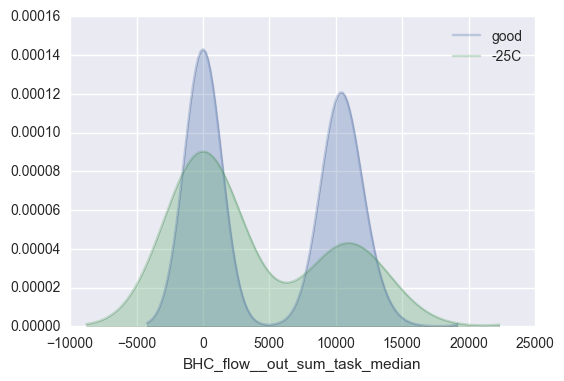

In [96]:
fig, ax = plt.subplots()
sns.distplot(good['BHC_flow__out_sum_task_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['BHC_flow__out_sum_task_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

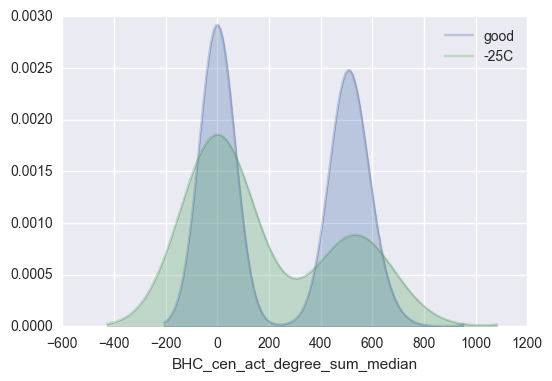

In [95]:
fig, ax = plt.subplots()
sns.distplot(good['BHC_cen_act_degree_sum_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['BHC_cen_act_degree_sum_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

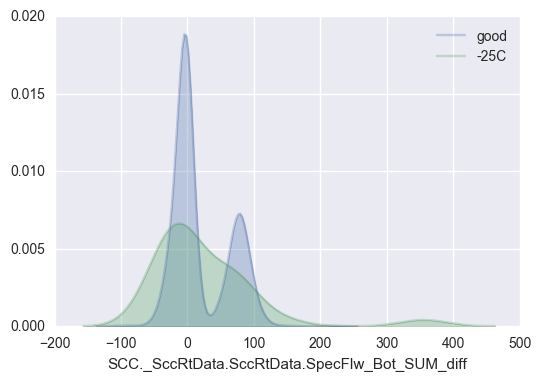

In [94]:
fig, ax = plt.subplots()
sns.distplot(good['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

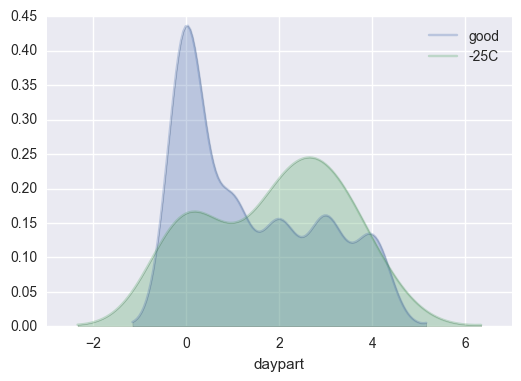

In [93]:
fig, ax = plt.subplots()
sns.distplot(good['daypart'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['daypart'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

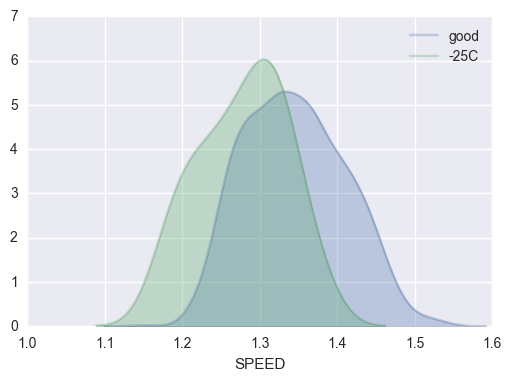

In [99]:
fig, ax = plt.subplots()
sns.distplot(good['SPEED'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['SPEED'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

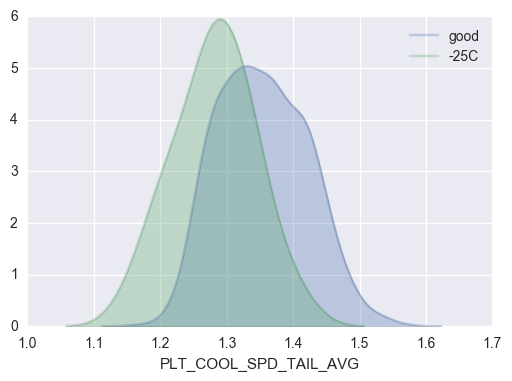

In [100]:
fig, ax = plt.subplots()
sns.distplot(good['PLT_COOL_SPD_TAIL_AVG'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['PLT_COOL_SPD_TAIL_AVG'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

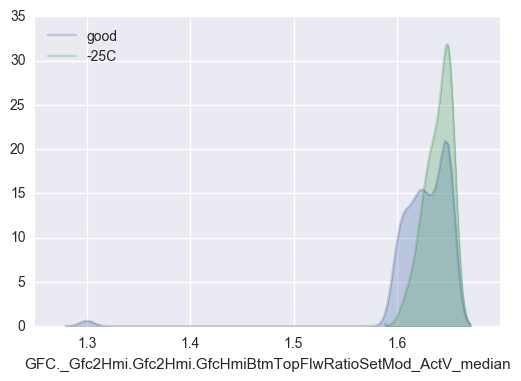

In [92]:
fig, ax = plt.subplots()
sns.distplot(good['GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMod_ActV_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMod_ActV_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

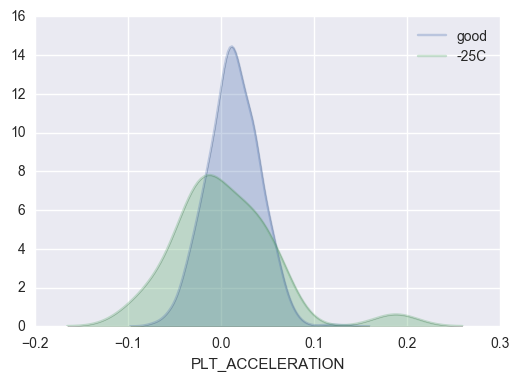

In [91]:
fig, ax = plt.subplots()
sns.distplot(good['PLT_ACCELERATION'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['PLT_ACCELERATION'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

b= pd.concat([suspdown[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
b.columns = ['index', 'susp40down_mean','good_mean']
b['diff']=0
b['diff'] = abs((b.susp40down_mean -b.good_mean)/(b['good_mean']))
b.sort_values(by='diff', ascending=0,inplace=1)

b.to_csv('./t/suspdown.csv',index=0, sep=';' )
b


,index,susp40down_mean,good_mean,diff
65,DIF_TMP_ALL,-54.165,0.080,682.261
81,GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMo...,0.001,0.000,40.473
50,DEF_CR,1.422,-0.064,23.374
56,DIF_LAM_BDY_TAIL,0.083,-0.008,11.347
53,DIF_BDY_TAIL,0.113,-0.011,11.335
58,DIF_SPRAY_BDY_TAIL,0.030,-0.003,11.303
244,ts_diff,5.369,-0.739,8.264
45,CR_PREV,0.386,-0.069,6.616
241,not40day,3.375,0.474,6.121
240,not25day,6.375,1.769,2.604


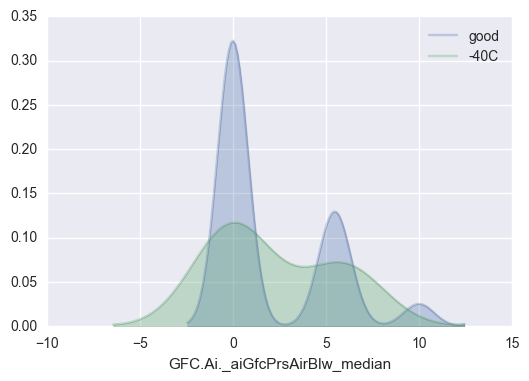

In [119]:
fig, ax = plt.subplots()
sns.distplot(good['GFC.Ai._aiGfcPrsAirBlw_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(suspdown['GFC.Ai._aiGfcPrsAirBlw_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-40C')

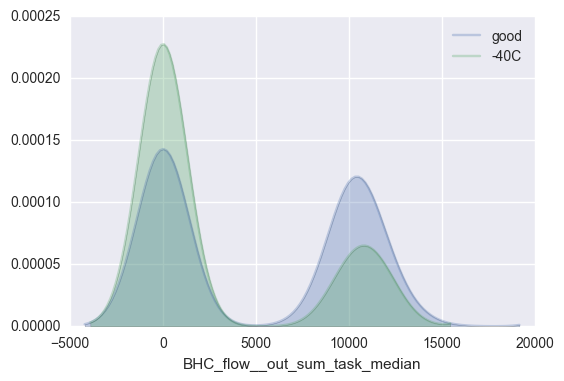

In [118]:
fig, ax = plt.subplots()
sns.distplot(good['BHC_flow__out_sum_task_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(suspdown['BHC_flow__out_sum_task_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-40C')

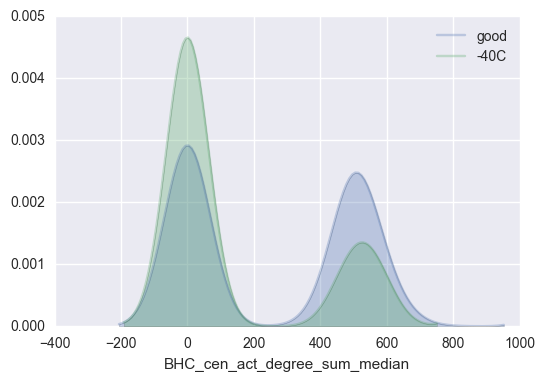

In [117]:
fig, ax = plt.subplots()
sns.distplot(good['BHC_cen_act_degree_sum_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(suspdown['BHC_cen_act_degree_sum_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-40C')

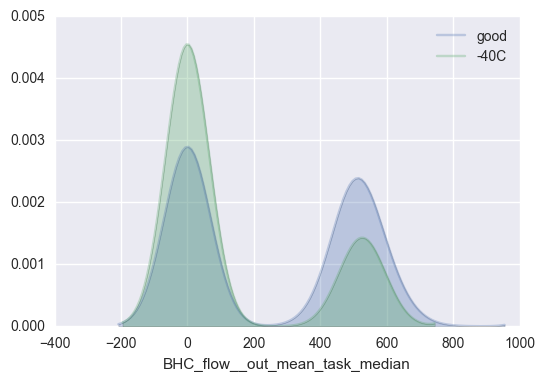

In [116]:
fig, ax = plt.subplots()
sns.distplot(good['BHC_flow__out_mean_task_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(suspdown['BHC_flow__out_mean_task_median'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-40C')

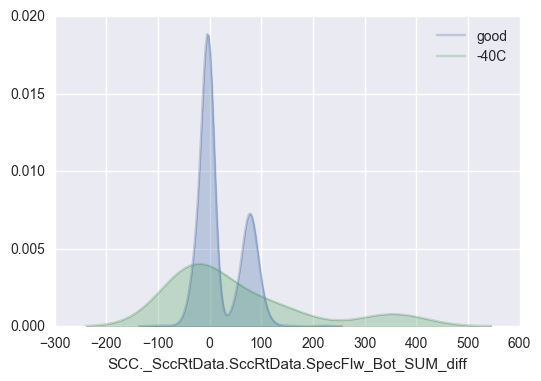

In [115]:
fig, ax = plt.subplots()
sns.distplot(good['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(suspdown['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-40C')

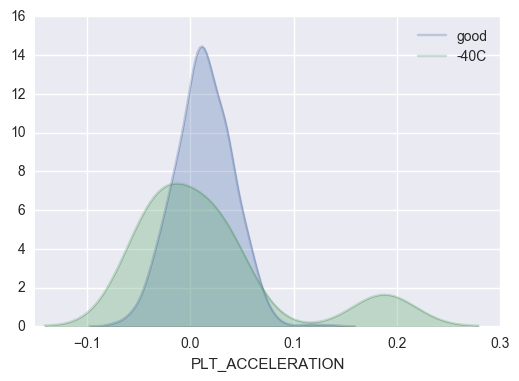

In [112]:
fig, ax = plt.subplots()
sns.distplot(good['PLT_ACCELERATION'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(suspdown['PLT_ACCELERATION'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-40C')

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',255)

c = pd.concat([fail25up[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
c.columns = ['index', 'fail25up_mean','good_mean']
c['diff']=0
c['diff'] = abs((c.fail25up_mean - c.good_mean)/(c['good_mean']))
c.sort_values(by='diff', ascending=0,inplace=1)

c.to_csv('./t/fail25up.csv',index=0, sep=';' )
c

,index,fail25up_mean,good_mean,diff
65,DIF_TMP_ALL,28.997,0.080,363.709
50,DEF_CR,-1.367,-0.064,20.505
242,prev_fail,0.121,0.010,11.327
96,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.018,0.002,6.860
244,ts_diff,-5.434,-0.739,6.352
45,CR_PREV,-0.297,-0.069,3.320
111,PLT_ACCELERATION,0.040,0.013,2.037
240,not25day,4.848,1.769,1.741
241,not40day,1.212,0.474,1.558
56,DIF_LAM_BDY_TAIL,0.004,-0.008,1.482


In [12]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',255)

d = pd.concat([fail40down[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
d.columns = ['index', 'fail40down_mean','good_mean']
d['diff']=0
d['diff'] = abs((d.fail40down_mean - d.good_mean)/(d['good_mean']))
d.sort_values(by='diff', ascending=0,inplace=1)


d.to_csv('./t/fail40down.csv',index=0, sep=';' )
d

,index,fail40down_mean,good_mean,diff
65,DIF_TMP_ALL,-50.615,0.080,637.619
81,GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMo...,0.001,0.000,29.162
242,prev_fail,0.273,0.010,26.736
50,DEF_CR,1.362,-0.064,22.419
244,ts_diff,7.093,-0.739,10.596
241,not40day,4.000,0.474,7.440
56,DIF_LAM_BDY_TAIL,0.038,-0.008,5.770
53,DIF_BDY_TAIL,0.052,-0.011,5.764
58,DIF_SPRAY_BDY_TAIL,0.014,-0.003,5.750
45,CR_PREV,0.265,-0.069,4.859


In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',255)

f = pd.concat([fail25down[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
f.columns = ['index', 'fail25down_mean','good_mean']
f['diff']=0
f['diff'] = abs((f.fail25down_mean - f.good_mean)/(f['good_mean']))
f.sort_values(by='diff', ascending=0,inplace=1)


f.to_csv('./t/fail25down.csv',index=0, sep=';' )
f

,index,fail25down_mean,good_mean,diff
65,DIF_TMP_ALL,-29.962,0.080,377.853
56,DIF_LAM_BDY_TAIL,0.133,-0.008,17.492
53,DIF_BDY_TAIL,0.180,-0.011,17.473
58,DIF_SPRAY_BDY_TAIL,0.047,-0.003,17.422
50,DEF_CR,0.832,-0.064,14.086
45,CR_PREV,-0.512,-0.069,6.444
242,prev_fail,0.050,0.010,4.085
241,not40day,1.450,0.474,2.059
64,DIF_TFM,1.285,-2.214,1.580
240,not25day,4.450,1.769,1.516
